# Breif SATPY overview w/ MODIS - VIIRS - MSI data

Data Used: located in shared folder

In [1]:
# Only packages required for this notebook but many more may be useful
import numpy as np
import matplotlib.pyplot as plt
from satpy import Scene, find_files_and_readers, DataQuery
from datetime import datetime
import os
from pathlib import Path
from satellite_data_processor import process_satellite_data

In [2]:
def plot_difference_histogram(
    corrected,
    uncorrected,
    *,
    percent=False,
    bins=100,
    range_percentile=99,
    title=None,
    ax=None
):
    """
    Plot a histogram of band differences (corrected - uncorrected).

    Parameters
    ----------
    corrected : ndarray
        Corrected band data
    uncorrected : ndarray
        Uncorrected band data
    percent : bool, optional
        If True, plot percent difference: 100 * (c - u) / u
    bins : int, optional
        Number of histogram bins
    range_percentile : float, optional
        Percentile used to limit histogram range (symmetric)
    title : str, optional
        Plot title
    ax : matplotlib axis, optional
        Existing axis to plot on

    Returns
    -------
    stats : dict
        Dictionary of summary statistics
    """

    # Compute difference
    if percent:
        with np.errstate(divide="ignore", invalid="ignore"):
            diff = 100.0 * (corrected - uncorrected) / uncorrected
        xlabel = "Percent difference (%)"
    else:
        diff = np.array(corrected - uncorrected)
        xlabel = "Difference (corrected − uncorrected)"

    # Flatten and remove NaNs/Infs
    diff = diff.ravel()
    diff = diff[np.isfinite(diff)]

    # Robust range using percentiles
    p = np.nanpercentile(np.abs(diff), range_percentile)
    hist_range = (-p, p)

    # Create axis if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))

    # Plot histogram
    ax.hist(diff, bins=bins, range=hist_range, histtype="stepfilled", alpha=0.7)

    # Statistics
    mean = np.nanmean(diff)
    median = np.nanmedian(diff)
    std = np.nanstd(diff)
    rmse = np.sqrt(np.nanmean(diff**2))

    # Overlay statistics
    ax.axvline(mean, linestyle="--", linewidth=2, label=f"Mean = {mean:.3g}")
    ax.axvline(median, linestyle=":", linewidth=2, label=f"Median = {median:.3g}")

    # Labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Pixel count")
    ax.legend()

    if title is not None:
        ax.set_title(title)

    stats = {
        "mean": mean,
        "median": median,
        "std": std,
        "rmse": rmse,
        "n_pixels": diff.size,
    }

    return stats


In [3]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="dask"
)


In [4]:
# Create symlink to fix the naming issue ... you may need to change this depending on your system
pyspectral_dir = Path.home() / 'Library/Application Support/pyspectral'
source = pyspectral_dir / 'rsr_modis_EOS-Aqua.h5'
target = pyspectral_dir / 'rsr_modis_Aqua.h5'

if source.exists() and not target.exists():
    os.symlink(source, target)
    print(f"Created symlink: {target} -> {source}")
else:
    print(f"Source exists: {source.exists()}, Target exists: {target.exists()}")

Source exists: True, Target exists: True


In [5]:
# CHANGE THIS ---------------------------------- (if running notebook in folder then Path('.') should work)
DATA_DIR = str(Path('~/Downloads').expanduser())

####  --- MODIS ---
Link below contains available composites as well as modifiers for corrections

https://github.com/pytroll/satpy/blob/main/satpy/etc/composites/modis.yaml


#### A Note On Corrections

* See https://satpy.readthedocs.io/en/latest/api/satpy.modifiers.geometry.html for geometric corrections

* See https://pyspectral.readthedocs.io/en/latest/rayleigh_correction.html for radiometric/atmospheric correction

This cell uses Satpy’s `find_files_and_readers` function to identify all files in the specified directory that can be read by the chosen reader.

**Note:** This function returns **all files within the requested time bounds**. If your directory contains MODIS data from both **Aqua and Terra**, files from *both platforms* will be returned, so take care to filter appropriately if you only want one sensor.

The resulting list of files is passed to the `Scene` class, which can ingest both radiance/reflectance files and their corresponding geolocation files automatically.

While the `Scene` class is very powerful, it can become unwieldy when handling multiple, temporally separated datasets. For this reason, it is recommended to create a **separate `Scene` instance for each analysis time**.

For example, rather than loading data for
`event_1 = (2023, 1, 3, 13, 0)` and
`event_2 = (2025, 1, 1, 3, 0)`
into a single `Scene`, you should create one `Scene` per event. This keeps each scene temporally consistent and avoids unintended file mixing.

Additionally, it is also recommended to create a **separate `Scene` instance for applying corrections to the data**. This is to help avoid issues with the load/unload functionality and ensure the correct procedures are being followed.


In [6]:
# note that I am only using one granule here...
myfiles = find_files_and_readers(base_dir=DATA_DIR,
                                 sensor="modis",
                                 start_time=datetime(2026, 1, 1, 12, 30),
                                 end_time=datetime(2026, 1, 1, 12, 30),
                                 reader='modis_l1b',)

# both uncorrected and corrected scenes are initialized
uncorrected_scn = Scene(filenames=myfiles)
corrected_scn = Scene(filenames=myfiles)

In [7]:
# The Scene can tell you what datasets are availabe to load based on the files that you have initialized the class with
# note that I have provided the Scene with the geolocation file.
print(uncorrected_scn.available_dataset_names())
print()
print(corrected_scn.available_dataset_names())

['1', '10', '11', '12', '13hi', '13lo', '14hi', '14lo', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '4', '5', '6', '7', '8', '9', 'height', 'landsea_mask', 'latitude', 'longitude', 'range', 'satellite_azimuth_angle', 'satellite_zenith_angle', 'solar_azimuth_angle', 'solar_zenith_angle', 'waterpresent']

['1', '10', '11', '12', '13hi', '13lo', '14hi', '14lo', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '4', '5', '6', '7', '8', '9', 'height', 'landsea_mask', 'latitude', 'longitude', 'range', 'satellite_azimuth_angle', 'satellite_zenith_angle', 'solar_azimuth_angle', 'solar_zenith_angle', 'waterpresent']


In [8]:
uncorrected_scn.load(['1', 'latitude','longitude', 'solar_zenith_angle'])
# corrected_scn.load(['latitude','longitude', 'solar_zenith_angle'])
corrected_scn.load(['1'], modifiers=['sunz_corrected'])

tc_scene = Scene(filenames=myfiles)



The following datasets were not created and may require resampling to be generated: DataID(name='1', wavelength=WavelengthRange(min=0.62, central=0.645, max=0.67, unit='µm'), resolution=1000, calibration=<1>, modifiers=('sunz_corrected',))


In [9]:
tc_scene.load(['true_color'])


The following datasets were not created and may require resampling to be generated: DataID(name='true_color')


In [10]:
tc_rs = tc_scene.resample(tc_scene.coarsest_area(),resampler='native')


In [11]:
array = np.transpose(tc_rs['true_color'].values, (1,2,0))

In [12]:
np.nanmax(array)

np.float32(174.42328)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7416731].


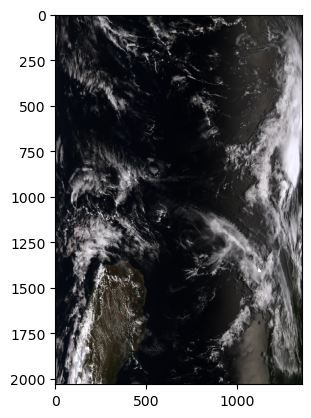

In [13]:
fig, ax = plt.subplots()
ax.imshow((array-np.nanmin(array)) / (100 - np.nanmin(array)))

In [14]:
resampled_cor = corrected_scn.resample(corrected_scn.coarsest_area(), resampler='native')
resampled_uncor = uncorrected_scn.resample(uncorrected_scn.coarsest_area(), resampler='native')


In [15]:
print(uncorrected_scn['1'].attrs['modifiers'])
print(resampled_cor['1'].attrs['modifiers'])

()
('sunz_corrected',)


In [16]:
print(resampled_uncor['1'].shape)
print(resampled_cor['1'].shape)

(2030, 1354)
(2030, 1354)


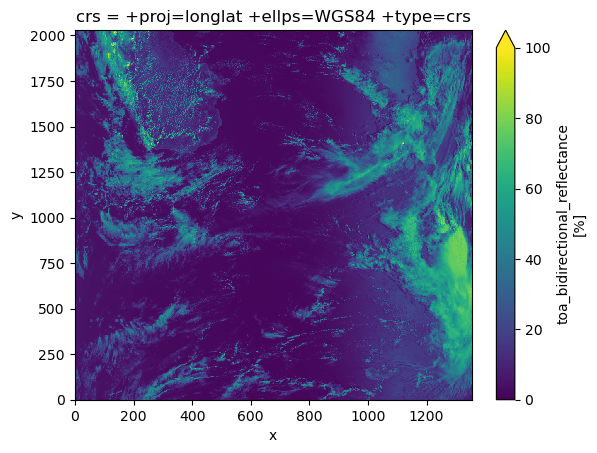

In [17]:
resampled_uncor['1'].plot(vmin=0, vmax=100)

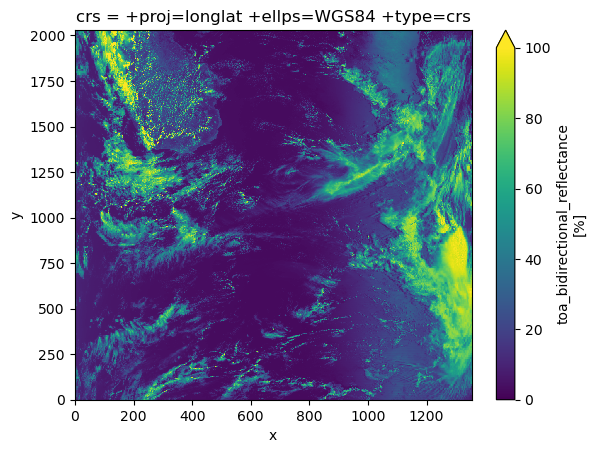

In [18]:
resampled_cor['1'].plot(vmin=0, vmax=100)

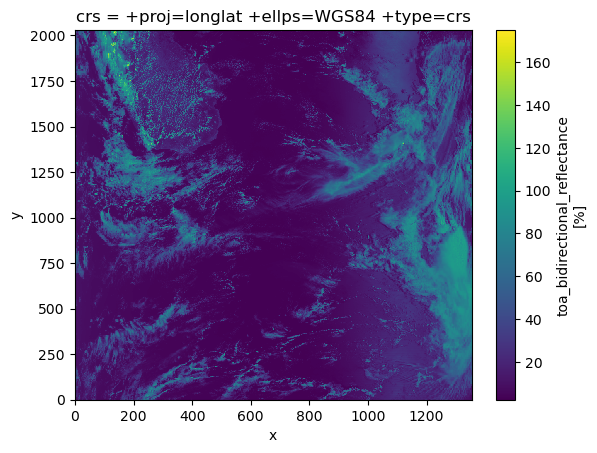

In [19]:
resampled_cor['1'].plot()

#### Loading Data

To access data from the `Scene` class the `.load` method is used to pull the data from the provided datasets. These datasets are built on xarray and dask so they are lazy loaded and need to be computed for any of the arrays to produce values. The `Scene` class holds all of these datasets and they can be acessed via slicing by key as shown later.

A safe and effective process for using the `.load` method is outlined below:

If no corrections:
* you can load all the data at once

If doing corrections:
* load data that does not require correction
* load data that requires minimal correction
* resample data
* load data that requires maximal correction
* resample again to same resampling method as above



In [ ]:
# uncorrected
uncorrected_scn.load(uncorrected_scn.available_dataset_names()[:-1]) # loads in all but the waterpresent (has issues)
print(uncorrected_scn)

In [ ]:
# corrected

# load in the geolocation datasets first
corrected_scn.load(['height', 'landsea_mask',
                    'latitude', 'longitude',
                    'range', 'satellite_azimuth_angle',
                    'satellite_zenith_angle', 'solar_azimuth_angle',
                    'solar_zenith_angle'])

In [ ]:
print(corrected_scn.available_dataset_names())

In [ ]:
# now that geolocaiton is loaded in proceed to adding bands with minimal correction ... in this case solar/satellite zenith corrections.
# I will do this for all but bands 1, 3, and 4 where I will apply additional correction in the next step

# corrections are applied by specifying the type of correction with the modifiers option as shown below
# note that the available modifiers can be found in the github doc link provided

corrected_scn.load(['10', '11', '12', '13hi', '13lo', '14hi',
                    '14lo', '15', '16', '17', '18', '19',
                    '2', '20', '21', '22', '23', '24',
                    '25', '26', '27', '28', '29', '30',
                    '31', '32', '33', '34', '35', '36',
                    '5', '6', '7', '8', '9'],
                   modifiers=['effective_solar_pathlength_corrected'])

# running with the modifiers may yield a warning that the dataset has not been loaded and resampling may be needed.
# we will discuss resampling in the last step but proceed with loading the next set of data

In [ ]:
corrected_scn.load(['1', '3', '4'], modifiers=['effective_solar_pathlength_corrected','rayleigh_corrected'])

#### Resampling the data

The `.resample` method is extremly important and it allows us to create the datasets that were not generated above as well as generate composites.
Different resamplings can be done and I suggest you take a look at the documentation but for the purposes of the project the data should
use the 'native' resampler to apply the correct satellite geometry data and projection to the datasets. By using the 'native' resampler
we are basically getting back the default pixels that the modis scanner is sensing while allowing for satpy to know that all the data is
on the same grid.

In [ ]:
# resample

# IMPORTANT --- SAVE THE NEW SCENE!!!!  just calling corrected_scn.resample() will not do anything you have to save as a variable!
modis_corrected_scn = corrected_scn.resample(resampler='native')

In [ ]:
# lets check that the datasets are loaded and have the correct modifiers
print(corrected_scn['10'].attrs['modifiers'])
print(modis_corrected_scn['10'].attrs['modifiers'])
print()
print(corrected_scn['1'].attrs['modifiers'])
print(modis_corrected_scn['1'].attrs['modifiers'])

In [ ]:
# lets take a look at the available default composites... These can also be found at the github link
# note that new composites can be made / generate ... see satpy documentation for more.
print(modis_corrected_scn.available_composite_names())

In [ ]:
# there is an uncorrected version of truecolor
uncorrected_scn.load(['true_color_uncorrected'])
# corrected more useful version ...
corrected_scn.load(['true_color'])

# note that corrected_scn is being used again... once you resample you dont have access to the composites... So make sure to load all the data you want included before resampling

# note that you do not have to load these with corrections as they will alread call the necessary corrections for you and handle it in the back end

# dont forget to resample...
resampled_uncorr = uncorrected_scn.resample(resampler='native')
resampled_corr = corrected_scn.resample(resampler='native')



In [ ]:
# modifiers can be checked for using the .prerequisites method for the composites. This shows each band used and its correction
print(resampled_uncorr['true_color_uncorrected'].prerequisites)
print()
print(resampled_corr['true_color'].prerequisites)

Note that resampled_uncorr now has sunz_corected as a modifier...

In [ ]:
# generate boolean array to see if band 1 has different values for corrected and uncorrected bands. We should expect they are mostly different...
_band1_boolean = resampled_corr['1'] == resampled_uncorr['1']
np_boolean_results = np.array(_band1_boolean)
numpy_true_count = np.sum(np_boolean_results)
numpy_false_count = np.sum(~np_boolean_results)

print('True count:', numpy_true_count)
print('False count:', numpy_false_count)

In [ ]:
resampled_uncorr['31'].attrs

In [ ]:
corrected_scn.available_dataset_ids()

In [ ]:
test = corrected_scn.load(['1'])

### Test Out Corrections

In [ ]:
# lets take a look at a histogram for difference values and their frequency of occurrence + some statistics
plot_difference_histogram(corrected=resampled_corr['1'], uncorrected=resampled_uncorr['1'])

In [ ]:
# raw uncorrected plot
%matplotlib inline

fig = plt.figure()
resampled_uncorr['1'].plot()
plt.show()


In [ ]:
uncorrected_scn['1'].attrs['area']

In [ ]:
resampled_corr['1'].plot(vmin=0)


In [ ]:
resampled_uncorr['31'].plot()

In [ ]:
print(corrected_scn.available_dataset_names())
print()
print(corrected_scn['solar_zenith_angle'])

In [ ]:
resampled_corr['31'].plot()

In [ ]:
resampled_corr['true_color']s

In [ ]:
fig, ax = plt.subplots()
ax.imshow(resampled_corr['true_color'])

In [ ]:
image = np.asarray(resampled_corr["true_color"]).transpose(1,2,0)
image = np.nan_to_num(image)
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))
crs = resampled_corr["true_color"].attrs["area"].to_cartopy_crs()


In [ ]:

import matplotlib.pyplot as plt
from satpy.writers import get_enhanced_image

plt.figure()
img = get_enhanced_image(resampled_corr['true_color'])
# get DataArray out of `XRImage` object
img_data = img.data
img_data.plot.imshow(rgb='bands', vmin=0, vmax=1)

In [ ]:
# Initiate a matplotlib figure
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(1, 1, 1, projection=crs)

# Specify coastlines
ax.coastlines(resolution="10m", color="white")

# Specify a grid
gl = ax.gridlines(draw_labels=True, linestyle='--', xlocs=range(-140,-110,5), ylocs=range(20,50,5))
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Plotting function
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")

# Set plot title
plt.title("Natural color composite of California, recorded by MODIS at " + scn['1'].attrs['start_time'].strftime("%Y-%m-%d %H:%M"), fontsize=20, pad=20.0)

# Show the plot
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(resampled_corr['1'])

In [ ]:
# raw corrected plot
fig, ax = plt.subplots()
ax.imshow(resampled_corr['1'])

In [ ]:
# diverging difference plot...
fig, ax = plt.subplots()
ax.imshow(resampled_corr['1']-resampled_uncorr['1'],
          cmap='bwr', vmin=-30, vmax=30)

### --- VIIRS ---

https://github.com/pytroll/satpy/blob/main/satpy/etc/composites/viirs.yaml

In [ ]:
viirs_files = find_files_and_readers(base_dir=DATA_DIR,
                                     start_time=datetime(2026, 1, 1, 12, 00),
                                     end_time=datetime(2026, 1, 1, 12, 00),
                                     reader='viirs_l1b',)
print(viirs_files)
print()

viirs_uncorrected_scn = Scene(filenames=viirs_files)
viirs_corrected_scn = Scene(filenames=viirs_files)

print(viirs_uncorrected_scn.all_dataset_names())

In [ ]:
viirs_data_load_list = viirs_uncorrected_scn.all_dataset_names()[1:22] + viirs_uncorrected_scn.all_dataset_names()[-8:]

viirs_uncorrected_scn.load(viirs_data_load_list)
# ignore the xarray warnings

In [ ]:
viirs_corrected_scn.load(['i_lat', 'i_lon', 'm_lat', 'm_lon',
                          'satellite_azimuth_angle', 'satellite_zenith_angle',
                          'solar_azimuth_angle', 'solar_zenith_angle'])

viirs_corrected_scn.load(['M01', 'M02','M04', 'M05', 'M06', 'M07', 'M08',
                          'M09', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16'],
                         modifiers=['sunz_corrected'])

# note that VIIRS has a separate correction for the I-bands
viirs_corrected_scn.load(['I01', 'I02', 'I03', 'I04', 'I05'],
                         modifiers=['sunz_corrected_iband'])

viirs_corrected_scn.load(['M03'], modifiers=['sunz_corrected', 'rayleigh_corrected'])

resampled_viirs = viirs_corrected_scn.resample(resampler='native')

print(viirs_corrected_scn['M01'].attrs['modifiers'])
print()
print(viirs_corrected_scn['I03'].attrs['modifiers'])
print()
print(viirs_corrected_scn['M03'].attrs['modifiers'])

### --- SENTINEL-2 ---

https://github.com/pytroll/satpy/blob/main/satpy/etc/composites/sen2_msi.yaml

In [ ]:
msi_files = find_files_and_readers(base_dir=DATA_DIR,
                                     start_time=datetime(2026, 1, 1, 12, 00),
                                     end_time=datetime(2026, 1, 1, 12, 00),
                                     reader='msi_safe',)
print(msi_files)
msi_uncorrected_scn = Scene(reader='msi_safe', filenames=msi_files)
msi_corrected_scn = Scene(filenames=msi_files)
print()
print(msi_uncorrected_scn.all_dataset_names())

In [ ]:
print(msi_corrected_scn.available_composite_names())

In [ ]:
msi_corrected_scn.load(['satellite_azimuth_angle', 'satellite_zenith_angle',
                        'solar_azimuth_angle', 'solar_zenith_angle'])

# msi does not hvae sunz_corrected ... instead they call 'effective_solar_pathlength_corrected' in their composites generation
# see https://satpy.readthedocs.io/en/latest/api/satpy.modifiers.geometry.html for details and research paper

msi_corrected_scn.load(['B01', 'B02', 'B04', 'B05', 'B06', 'B07',
                        'B08', 'B09', 'B10', 'B11', 'B12', 'B8A'],
                       modifiers=['effective_solar_pathlength_corrected'])

msi_corrected_scn.load(['B03'], modifiers=['effective_solar_pathlength_corrected', 'rayleigh_corrected'])

msi_corrected_scn.load(['true_color'])

resampled_corrected_msi = msi_corrected_scn.resample(resampler='native')

print(resampled_corrected_msi['B01'].attrs['modifiers'])
print()
print(resampled_corrected_msi['B03'].attrs['modifiers'])
print()
print(resampled_corrected_msi['true_color'].prerequisites)



## Using `process_satellite_data` function from satellite_data_processor.py

In [ ]:
data_dir = DATA_DIR
data_dir

In [ ]:
load_recipes = [(['1', '3', '4'], ['sunz_corrected', 'rayleigh_corrected']),
                (['true_color'], [])]

In [ ]:
# datasets = process_satellite_data(
#     data_dir=data_dir,
#     satpy_reader='modis_l1b',
#     start_time='20260101T1230',
#     end_time='20260101T1230',
#     satellite_name='Aqua',
#     satellite_instrument='MODIS',
#     load_recipes=load_recipes,
#     save_path=Path('~/Downloads').expanduser(),
#     correction_type='both'
# )

In [ ]:
file_list = find_files_and_readers(base_dir=DATA_DIR,
                                   start_time=datetime(2026, 1, 1, 12, 00),
                                   end_time=datetime(2026, 1, 1, 12, 00),
                                   reader='viirs_l1b')

scene = Scene(file_list)

In [ ]:
data_names = scene.available_dataset_names()
print(data_names)

In [ ]:
print(scene['B12'].standard_name)

In [ ]:
scene.load(data_names[:])

In [ ]:
for x in data_names:
    try:
        print(scene[x].standard_name, '   ---->    ', x)
    except:
        print(x)
        continue